# face **recognition**

# Requirements: pip install numpy opencv-python scikit-image scikit-learn matplotlib

In [ ]:
pip install numpy opencv-python scikit-image scikit-learn matplotlib

# **Single-file demo implementing multiple face-recognition approaches (local/keypoints, local/appearance, holistic linear, holistic non-linear, and hybrid) using the LFW dataset.**

Steps for each approach:
 - Face detection (OpenCV Haar cascade)
 - Feature extraction (method-specific)
 - Recognition / classification (k-NN, SVM or descriptor matching)

In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern, hog
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# ------------------------------------------------------------------
#  Utility / dataset loading / face detection
# ------------------------------------------------------------------

In [ ]:
def load_lfw_dataset(min_faces_per_person=20, resize=0.5):
    """
    Loads LFW people dataset from sklearn and returns images and labels.
    Images are grayscale float32 in range [0,1].
    """
    lfw = fetch_lfw_people(min_faces_per_person=min_faces_per_person, resize=resize, color=False)
    images = lfw.images.astype(np.float32) / 255.0
    labels = lfw.target
    label_names = lfw.target_names
    print(f"Loaded LFW: {images.shape[0]} images, shape {images.shape[1:]} , {len(label_names)} identities")
    return images, labels, label_names

# Haar cascade (OpenCV) face detector function

In [ ]:
haar_xml = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(haar_xml)
if face_cascade.empty():
    raise RuntimeError("Could not load Haar cascade xml. Check OpenCV installation.")

# Detects face(s) in a grayscale image using Haar cascade.
#    Returns the largest detected face cropped as a grayscale image.

In [ ]:
def detect_face_opencv(img_gray, min_size=(30, 30)):
    img_uint8 = (img_gray * 255).astype(np.uint8) if img_gray.dtype != np.uint8 else img_gray
    faces = face_cascade.detectMultiScale(img_uint8, scaleFactor=1.1, minNeighbors=5, minSize=min_size)
    if len(faces) == 0:
        return None  # no face found
    # choose largest face
    x, y, w, h = max(faces, key=lambda r: r[2] * r[3])
    face = img_uint8[y:y+h, x:x+w]
    face = cv2.resize(face, (128, 128))  # unify size for downstream feature extraction
    face = face.astype(np.float32) / 255.0
    return face

# For LFW dataset images we already have faces (aligned). A helper to get detection for images from dataset (skip detection if None).

In [ ]:
def ensure_face(img):
    # img is grayscale in [0,1]
    detected = detect_face_opencv(img)
    if detected is None:
        # fallback: resize original to 128x128
        return cv2.resize((img*255).astype(np.uint8), (128,128)).astype(np.float32)/255.0
    return detected

# ------------------------------------------------------------------
#  Local — Keypoints-based (ORB) step-by-step
# ------------------------------------------------------------------

# ORB detector/descriptor

In [ ]:
orb = cv2.ORB_create(nfeatures=500)

In [ ]:
print(orb)

< cv2.ORB 0x7b5dd74bc5d0>


In [ ]:
def extract_orb_descriptors(face_img):
    """
    face_img: grayscale in [0,1], shape (H,W)
    returns keypoints and descriptors (uint8)
    """
    face_uint8 = (face_img * 255).astype(np.uint8)
    kps, des = orb.detectAndCompute(face_uint8, None)
    return kps, des

In [ ]:

def match_orb(des_query, des_gallery, ratio_thresh=0.75):
    """
    Brute-force Hamming matcher + ratio test like Lowe.
    Returns number of good matches and match ratio.
    """
    if des_query is None or des_gallery is None:
        return 0, 0.0
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(des_query, des_gallery, k=2)
    good = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good.append(m)
    return len(good), len(good) / max(1, len(matches))

In [ ]:
def build_orb_gallery(images):
    """
    Build gallery: compute descriptors for each gallery image.
    Returns list of descriptors and corresponding label indices.
    """
    descs = []
    for img in images:
        face = ensure_face(img)
        _, des = extract_orb_descriptors(face)
        descs.append(des)
    return descs

In [ ]:

def recognize_orb(des_query, gallery_descs, gallery_labels, threshold_matches=15):
    """
    Compare the query descriptor to all gallery descriptors, choose best by number of good matches.
    If best match >= threshold_matches return that label, else None.
    """
    best_count = 0
    best_label = None
    for des_g, lab in zip(gallery_descs, gallery_labels):
        cnt, _ = match_orb(des_query, des_g)
        if cnt > best_count:
            best_count = cnt
            best_label = lab
    if best_count >= threshold_matches:
        return best_label, best_count
    return None, best_count


# ------------------------------------------------------------------
#  Local — Local-appearance-based (LBP and HOG)
# ------------------------------------------------------------------

In [ ]:
def extract_lbp_hist(face_img, P=8, R=1, grid_x=8, grid_y=8, method='default'):
    """
    Compute LBP map and histogram pooling over grid cells.
    face_img: grayscale in [0,1] -> convert to uint8.
    returns concatenated hist vector (L1 normalized)
    """
    img_u8 = (face_img * 255).astype(np.uint8)
    lbp = local_binary_pattern(img_u8, P=P, R=R, method=method)
    # build histograms per grid cell
    h, w = lbp.shape
    gx = np.linspace(0, w, grid_x + 1, dtype=int)
    gy = np.linspace(0, h, grid_y + 1, dtype=int)
    n_bins = int(lbp.max() + 1)
    features = []
    for i in range(grid_y):
        for j in range(grid_x):
            cell = lbp[gy[i]:gy[i+1], gx[j]:gx[j+1]]
            hist, _ = np.histogram(cell.ravel(), bins=n_bins, range=(0, n_bins))
            features.append(hist)
    feat = np.concatenate(features).astype(np.float32)
    feat /= (feat.sum() + 1e-9)
    return feat

In [ ]:

def extract_hog_descriptor(face_img, pixels_per_cell=(16,16), cells_per_block=(2,2), orientations=9):
    """
    Uses skimage hog to produce a HOG vector (already normalized).
    """
    img_u8 = (face_img * 255).astype(np.uint8)
    vec = hog(img_u8, orientations=orientations, pixels_per_cell=pixels_per_cell,
              cells_per_block=cells_per_block, block_norm='L2-Hys', feature_vector=True)
    return vec.astype(np.float32)


# ------------------------------------------------------------------
#  Holistic — Linear (PCA, LDA) and Non-linear (KernelPCA + SVM)
# ------------------------------------------------------------------

In [ ]:
def prepare_flat_images(images, target_size=(128,128)):
    """
    Ensure images are faces of target_size and flatten them to vectors.
    """
    vecs = []
    for img in images:
        face = ensure_face(img)
        face_resized = cv2.resize((face*255).astype(np.uint8), target_size).astype(np.float32)/255.0
        vecs.append(face_resized.flatten())
    X = np.vstack(vecs).astype(np.float32)
    return X

# PCA / eigenfaces

In [ ]:
def train_pca_classifier(X_train, y_train, n_components=150):
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X_train)
    pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True, random_state=42)
    Xp = pca.fit_transform(Xs)
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(Xp, y_train)
    return {'scaler': scaler, 'pca': pca, 'clf': clf}



In [ ]:
def pca_predict(pca_model, X_query):
    Xs = pca_model['scaler'].transform(X_query)
    Xp = pca_model['pca'].transform(Xs)
    pred = pca_model['clf'].predict(Xp)
    return pred

# LDA (Fisherfaces) - LDA needs fewer components and supervised info

In [ ]:
def train_lda_classifier(X_train, y_train, n_components=None):
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X_train)
    # LDA often expects n_components <= n_classes - 1
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    lda.fit(Xs, y_train)
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(lda.transform(Xs), y_train)
    return {'scaler': scaler, 'lda': lda, 'clf': clf}

In [ ]:
def lda_predict(lda_model, X_query):
    Xs = lda_model['scaler'].transform(X_query)
    Xt = lda_model['lda'].transform(Xs)
    pred = lda_model['clf'].predict(Xt)
    return pred

# Non-linear: KernelPCA + SVM

In [ ]:
def train_kpca_svm(X_train, y_train, n_components=200, kernel='rbf'):
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X_train)
    kpca = KernelPCA(n_components=n_components, kernel=kernel, fit_inverse_transform=False, random_state=42)
    Xk = kpca.fit_transform(Xs)
    svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
    svm.fit(Xk, y_train)
    return {'scaler': scaler, 'kpca': kpca, 'svm': svm}

In [ ]:

def kpca_svm_predict(model, X_query):
    Xs = model['scaler'].transform(X_query)
    Xk = model['kpca'].transform(Xs)
    pred = model['svm'].predict(Xk)
    probs = model['svm'].predict_proba(Xk)
    return pred, probs

# ------------------------------------------------------------------
#  Hybrid: combine local (LBP) + holistic (PCA) features and SVM
# ------------------------------------------------------------------


In [ ]:
def build_hybrid_features(images, pca_components=100):
    """
    For each image: LBP hist features + PCA low-dim projection of the flattened face.
    Returns matrix of features.
    """
    lbp_feats = []
    flat_faces = []
    for img in images:
        face = ensure_face(img)
        lbp = extract_lbp_hist(face, grid_x=6, grid_y=6)  # moderate dimension
        lbp_feats.append(lbp)
        flat_faces.append(cv2.resize((face*255).astype(np.uint8), (128,128)).astype(np.float32).flatten())
    X_flat = np.vstack(flat_faces)
    scaler_flat = StandardScaler().fit(X_flat)
    Xs = scaler_flat.transform(X_flat)
    pca = PCA(n_components=min(pca_components, Xs.shape[0]-1), whiten=True, random_state=42)
    Xp = pca.fit_transform(Xs)
    X_hybrid = np.hstack([np.vstack(lbp_feats), Xp])
    return X_hybrid, {'scaler_flat': scaler_flat, 'pca': pca}

In [ ]:

def train_hybrid_svm(X_hybrid, y_train):
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X_hybrid)
    svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
    svm.fit(Xs, y_train)
    return {'scaler': scaler, 'svm': svm}

In [ ]:
def hybrid_predict(hybrid_model, pca_info, query_face):
    """
    query_face: grayscale [0,1] face image
    """
    # --- Extract local feature (LBP)
    lbp = extract_lbp_hist(query_face, grid_x=6, grid_y=6)
    lbp = lbp.reshape(1, -1)  # ensure 2D

    # --- Extract holistic feature (PCA projection)
    flat = cv2.resize((query_face * 255).astype(np.uint8), (128, 128)).astype(np.float32).flatten().reshape(1, -1)
    flat_s = pca_info['scaler_flat'].transform(flat)
    flat_p = pca_info['pca'].transform(flat_s)  # already 2D

    # --- Combine (hybrid feature vector)
    feat = np.hstack([lbp, flat_p])

    # --- Predict with trained SVM
    feat_scaled = hybrid_model['scaler'].transform(feat)
    pred = hybrid_model['svm'].predict(feat_scaled)
    probs = hybrid_model['svm'].predict_proba(feat_scaled)
    return pred, probs


# ------------------------------------------------------------------
#  Training / orchestration
# ------------------------------------------------------------------



    Trains or prepares all models for the demo.
    Returns a dict with trained models and required objects.



In [ ]:
def train_all_models(images, labels, label_names):
    """
    Trains or prepares all models for the demo.
    Returns a dict with trained models and required objects.
    """
    print("Preparing flat images...")
    X = prepare_flat_images(images)  # flattened faces
    y = labels

    # split dataset
    X_train, X_test, y_train, y_test, imgs_train, imgs_test = train_test_split(
        X, y, images, test_size=0.25, stratify=y, random_state=42)

    print("Training PCA (eigenfaces) + kNN classifier...")
    pca_model = train_pca_classifier(X_train, y_train, n_components=min(150, X_train.shape[0]-1))
    y_pred_pca = pca_model['clf'].predict(pca_model['pca'].transform(pca_model['scaler'].transform(X_test)))
    print("PCA-kNN test acc:", accuracy_score(y_test, y_pred_pca))

    print("Training LDA (Fisherfaces) + kNN ...")
    # choose LDA n_components automatically (<= n_classes -1)
    lda_model = train_lda_classifier(X_train, y_train, n_components=None)
    lda_pred = lda_model['clf'].predict(lda_model['lda'].transform(lda_model['scaler'].transform(X_test)))
    print("LDA-kNN test acc:", accuracy_score(y_test, lda_pred))

    print("Training KernelPCA + SVM ... (may take a bit)")
    kpca_model = train_kpca_svm(X_train, y_train, n_components=min(200, X_train.shape[0]-1), kernel='rbf')
    kpca_pred, _ = kpca_svm_predict(kpca_model, X_test)
    print("KPCA-SVM test acc:", accuracy_score(y_test, kpca_pred))

    print("Building ORB gallery descriptors...")
    # build descriptors for the *gallery set* (we'll use X_train images converted back to faces)
    # We need the original face images for descriptor extraction -> use imgs_train
    gallery_descs = build_orb_gallery(imgs_train)
    gallery_labels_for_orb = y_train.tolist()

    print("Building LBP/HOG feature sets and training SVM classifiers...")
     # LBP features
    lbp_feats = []
    for img in imgs_train:
        face = ensure_face(img)
        lbp_feats.append(extract_lbp_hist(face, grid_x=6, grid_y=6))
    X_lbp = np.vstack(lbp_feats)
    lbp_scaler = StandardScaler().fit(X_lbp)
    X_lbp_s = lbp_scaler.transform(X_lbp)
    lbp_svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
    lbp_svm.fit(X_lbp_s, y_train)

    # HOG features
    hog_feats = []
    for img in imgs_train:
        face = ensure_face(img)
        hog_feats.append(extract_hog_descriptor(face, pixels_per_cell=(16,16)))
    X_hog = np.vstack(hog_feats)
    hog_scaler = StandardScaler().fit(X_hog)
    X_hog_s = hog_scaler.transform(X_hog)
    hog_svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
    hog_svm.fit(X_hog_s, y_train)
      # Hybrid features
    X_hybrid, pca_info = build_hybrid_features(imgs_train, pca_components=100)
    hybrid_model = train_hybrid_svm(X_hybrid, y_train)

    print("Training complete. Returning models.")
    models = {
        'pca_model': pca_model,
        'lda_model': lda_model,
        'kpca_model': kpca_model,
        'orb_gallery': {
            'descs': gallery_descs,
            'labels': gallery_labels_for_orb,
            'threshold_matches': 15
        },
        'lbp_svm': {'svm': lbp_svm, 'scaler': lbp_scaler},
        'hog_svm': {'svm': hog_svm, 'scaler': hog_scaler},
        'hybrid_model': hybrid_model,
        'hybrid_pca_info': pca_info,
        'label_names': label_names,
        'imgs_train': imgs_train,
        'y_train': y_train
    }
    return models


# ------------------------------------------------------------------
#  Final test function that runs all methods on an input image
# ------------------------------------------------------------------

In [ ]:
def predict_all_methods(models, input_img_path):
    """
    Loads input image, runs face detection, then runs all methods and prints
    their prediction. Returns a dict of results.
    """
    # read input image grayscale
    img_bgr = cv2.imread(input_img_path)
    if img_bgr is None:
        raise FileNotFoundError(f"Could not read {input_img_path}")
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0

    face = detect_face_opencv(img_gray)
    if face is None:
        print("No face detected in input image.")
        face = cv2.resize(img_gray, (128,128)).astype(np.float32)

    results = {}

    # 1. ORB (key-point based matching)
    kps_q, des_q = extract_orb_descriptors(face)
    orb_gallery = models['orb_gallery']
    lab_orb, match_count = recognize_orb(des_q, orb_gallery['descs'], orb_gallery['labels'], orb_gallery['threshold_matches'])
    results['orb'] = {'label_index': lab_orb, 'matches': match_count}
    if lab_orb is not None:
        print(f"[ORB] Matched label idx {lab_orb}  matches={match_count} => {models['label_names'][lab_orb]}")
    else:
        print(f"[ORB] No confident match (best matches={match_count})")

    # 2. Local-appearance LBP
    lbp_v = extract_lbp_hist(face, grid_x=6, grid_y=6)
    lbp_s = models['lbp_svm']['scaler'].transform(lbp_v.reshape(1,-1))
    lbp_pred = models['lbp_svm']['svm'].predict(lbp_s)[0]
    lbp_prob = models['lbp_svm']['svm'].predict_proba(lbp_s).max()
    results['lbp'] = {'label_index': int(lbp_pred), 'prob': float(lbp_prob)}
    print(f"[LBP-SVM] Pred: {models['label_names'][lbp_pred]}  prob={lbp_prob:.3f}")

    # 3. Local-appearance HOG
    hog_v = extract_hog_descriptor(face, pixels_per_cell=(16,16))
    hog_s = models['hog_svm']['scaler'].transform(hog_v.reshape(1,-1))
    hog_pred = models['hog_svm']['svm'].predict(hog_s)[0]
    hog_prob = models['hog_svm']['svm'].predict_proba(hog_s).max()
    results['hog'] = {'label_index': int(hog_pred), 'prob': float(hog_prob)}
    print(f"[HOG-SVM] Pred: {models['label_names'][hog_pred]}  prob={hog_prob:.3f}")

    # 4. Holistic PCA
    flat_q = cv2.resize((face*255).astype(np.uint8), (128,128)).astype(np.float32).flatten().reshape(1,-1)
    pca_pred = pca_predict(models['pca_model'], flat_q)[0]
    results['pca'] = {'label_index': int(pca_pred)}
    print(f"[PCA-kNN] Pred: {models['label_names'][pca_pred]}")

    # 5. Holistic LDA
    lda_pred = lda_predict(models['lda_model'], flat_q)[0]
    results['lda'] = {'label_index': int(lda_pred)}
    print(f"[LDA-kNN] Pred: {models['label_names'][lda_pred]}")

    # 6. Holistic non-linear (KPCA + SVM)
    kpca_pred, kpca_probs = kpca_svm_predict(models['kpca_model'], flat_q)
    results['kpca_svm'] = {'label_index': int(kpca_pred[0]), 'prob': float(kpca_probs.max())}
    print(f"[KPCA-SVM] Pred: {models['label_names'][int(kpca_pred[0])]}  prob={kpca_probs.max():.3f}")

    # 7. Hybrid (LBP + PCA) + SVM
    hybrid_pred, hybrid_probs = hybrid_predict(models['hybrid_model'], models['hybrid_pca_info'], face)
    results['hybrid'] = {'label_index': int(hybrid_pred[0]), 'prob': float(hybrid_probs.max())}
    print(f"[Hybrid LBP+PCA SVM] Pred: {models['label_names'][int(hybrid_pred[0])]}  prob={hybrid_probs.max():.3f}")

    return results

# ------------------------------------------------------------------
#  Run training and demonstrate on an example image
# ------------------------------------------------------------------
# ------------------------------------------------------------------
#  Run training and demonstrate on an example image (Colab-friendly)
# ------------------------------------------------------------------


In [ ]:
if __name__ == "__main__":
    # 1) Load dataset
    imgs, labels, names = load_lfw_dataset(min_faces_per_person=10, resize=0.5)

    # 2) Train models
    models = train_all_models(imgs, labels, names)

    # 3) Test image path (upload your own or use one from the dataset)
    test_img_path ="/content/trump.jpg"  # e.g. "test_face.jpg"
    if test_img_path:
        print("\n--- Running all methods on test image ---")
        results = predict_all_methods(models, test_img_path)
        print("Results dict:", results)
    else:
        print("\nTraining complete. No test image given.")

Loaded LFW: 1140 images, shape (62, 47) , 5 identities
Preparing flat images...
Training PCA (eigenfaces) + kNN classifier...
PCA-kNN test acc: 0.10526315789473684
Training LDA (Fisherfaces) + kNN ...
LDA-kNN test acc: 0.20701754385964913
Training KernelPCA + SVM ... (may take a bit)
KPCA-SVM test acc: 0.4666666666666667
Building ORB gallery descriptors...
Building LBP/HOG feature sets and training SVM classifiers...
Training complete. Returning models.

--- Running all methods on test image ---
[ORB] No confident match (best matches=0)
[LBP-SVM] Pred: Colin Powell  prob=0.458
[HOG-SVM] Pred: Colin Powell  prob=0.458
[PCA-kNN] Pred: George W Bush
[LDA-kNN] Pred: Colin Powell
[KPCA-SVM] Pred: Colin Powell  prob=0.458
[Hybrid LBP+PCA SVM] Pred: George W Bush  prob=0.455
Results dict: {'orb': {'label_index': None, 'matches': 0}, 'lbp': {'label_index': 0, 'prob': 0.4582984507633657}, 'hog': {'label_index': 0, 'prob': 0.4582989472272578}, 'pca': {'label_index': 2}, 'lda': {'label_index': 0}

# ------------------------------------------------------------------
# ------------------------------------------------------------------
# visualization effect de chaque fonction
# ------------------------------------------------------------------
# ------------------------------------------------------------------

# **🧩 1️⃣ Face Detection Visualization**

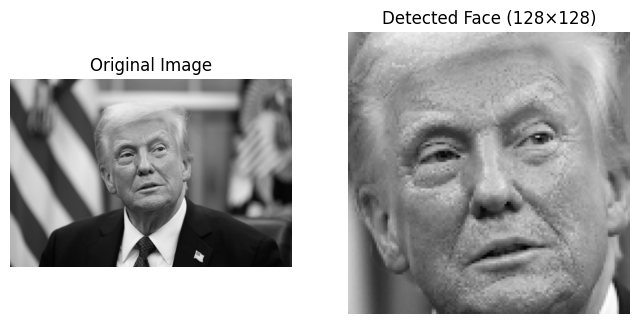

In [ ]:
import matplotlib.pyplot as plt

def visualize_face_detection(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)/255.0
    face = detect_face_opencv(gray)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(gray, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1,2,2)
    if face is not None:
        plt.imshow(face, cmap='gray')
        plt.title("Detected Face (128×128)")
    else:
        plt.text(0.5,0.5,"No Face Detected",ha='center')
    plt.axis('off')
    plt.show()

# Example
img = cv2.imread("/content/trump.jpg")
visualize_face_detection(img)


# **🔹 2️⃣ ORB Keypoints Visualization**

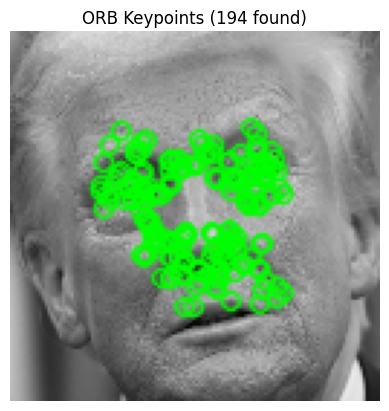

In [ ]:
def visualize_orb_keypoints(img):
    face = ensure_face(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)/255.0)
    kps, des = extract_orb_descriptors(face)
    img_kp = cv2.drawKeypoints((face*255).astype(np.uint8), kps, None, color=(0,255,0))
    plt.imshow(img_kp, cmap='gray')
    plt.title(f"ORB Keypoints ({len(kps)} found)")
    plt.axis('off')
    plt.show()

# Example
visualize_orb_keypoints(img)


# **🔹 3️⃣ LBP Feature Visualization**

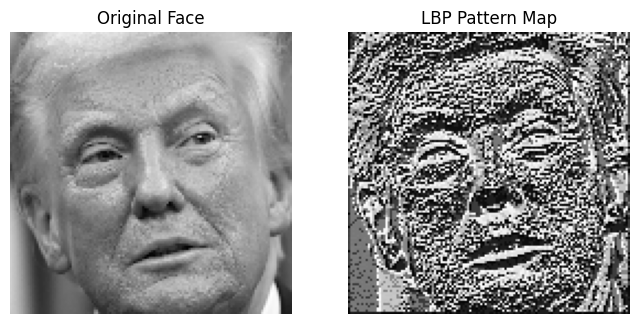

In [ ]:
def visualize_lbp(face):
    img_u8 = (face*255).astype(np.uint8)
    lbp = local_binary_pattern(img_u8, P=8, R=1, method='default')
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img_u8, cmap='gray')
    plt.title("Original Face")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(lbp, cmap='gray')
    plt.title("LBP Pattern Map")
    plt.axis('off')
    plt.show()

# Example
gray_face = ensure_face(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)/255.0)
visualize_lbp(gray_face)


# **🔹 4️⃣ HOG Feature Visualization**

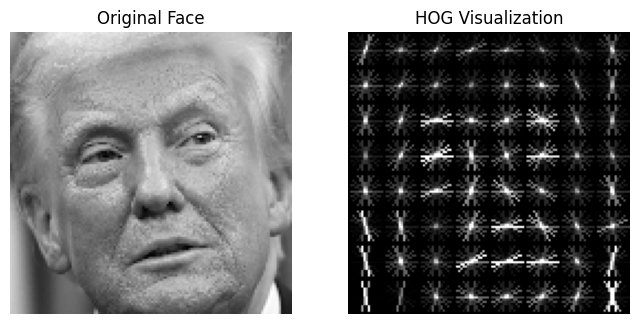

In [ ]:
from skimage import exposure

def visualize_hog(face):
    img_u8 = (face*255).astype(np.uint8)
    features, hog_image = hog(img_u8, orientations=9, pixels_per_cell=(16,16),
                              cells_per_block=(2,2), visualize=True, block_norm='L2-Hys')
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0,10))
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img_u8, cmap='gray')
    plt.title("Original Face")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(hog_image_rescaled, cmap='gray')
    plt.title("HOG Visualization")
    plt.axis('off')
    plt.show()

# Example
visualize_hog(gray_face)


# **🔹 5️⃣ PCA Eigenfaces Visualization**

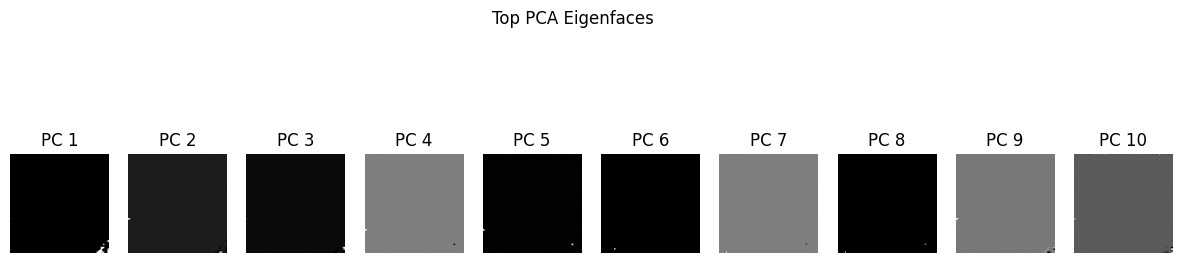

In [ ]:
def visualize_pca_components(pca_model, n_show=10):
    eigenfaces = pca_model['pca'].components_.reshape((-1,128,128))
    plt.figure(figsize=(15,4))
    for i in range(min(n_show, len(eigenfaces))):
        plt.subplot(1, n_show, i+1)
        plt.imshow(eigenfaces[i], cmap='gray')
        plt.title(f"PC {i+1}")
        plt.axis('off')
    plt.suptitle("Top PCA Eigenfaces")
    plt.show()

# Example
visualize_pca_components(models['pca_model'])


# **🔹 6️⃣ LDA Class Separation Visualization (2D)**

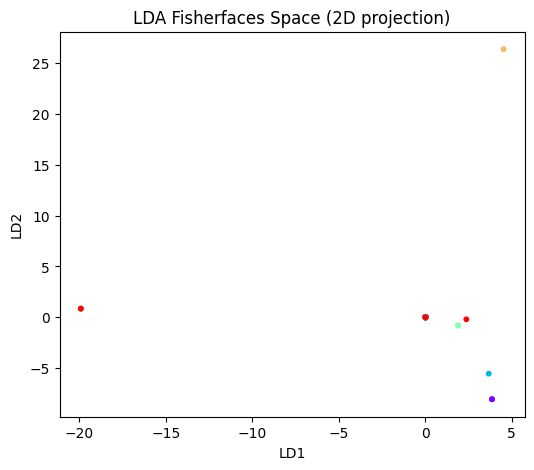

In [ ]:
def visualize_lda_space(model, X, y):
    Xs = model['scaler'].transform(X)
    X_lda = model['lda'].transform(Xs)
    plt.figure(figsize=(6,5))
    plt.scatter(X_lda[:,0], X_lda[:,1], c=y, cmap='rainbow', s=10)
    plt.title("LDA Fisherfaces Space (2D projection)")
    plt.xlabel("LD1")
    plt.ylabel("LD2")
    plt.show()

# Example
X = prepare_flat_images(imgs)
visualize_lda_space(models['lda_model'], X, labels)


# **🔹 7️⃣ ORB Match Visualization**

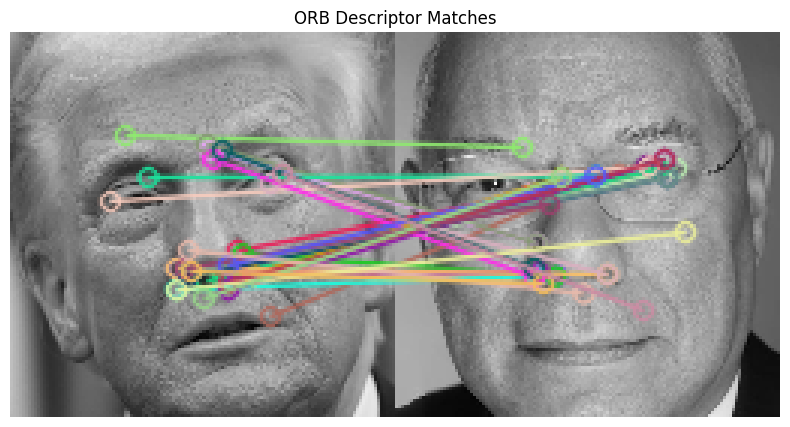

In [ ]:
def visualize_orb_matches(img1, img2):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY).astype(np.float32)/255.0
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY).astype(np.float32)/255.0
    face1 = ensure_face(gray1)
    face2 = ensure_face(gray2)
    kps1, des1 = extract_orb_descriptors(face1)
    kps2, des2 = extract_orb_descriptors(face2)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x:x.distance)[:30]
    img_match = cv2.drawMatches((face1*255).astype(np.uint8), kps1,
                                (face2*255).astype(np.uint8), kps2,
                                matches, None, flags=2)
    plt.figure(figsize=(10,5))
    plt.imshow(img_match)
    plt.title("ORB Descriptor Matches")
    plt.axis('off')
    plt.show()

# Example: compare two known faces
visualize_orb_matches(cv2.imread("/content/trump.jpg"),
                      cv2.imread("/content/2020_Performers_ColinPowell.jpeg"))


# **🔹 8️⃣ Hybrid Feature Visualization (LBP + PCA)**

LBP vector length: 9216
PCA projection length: 100


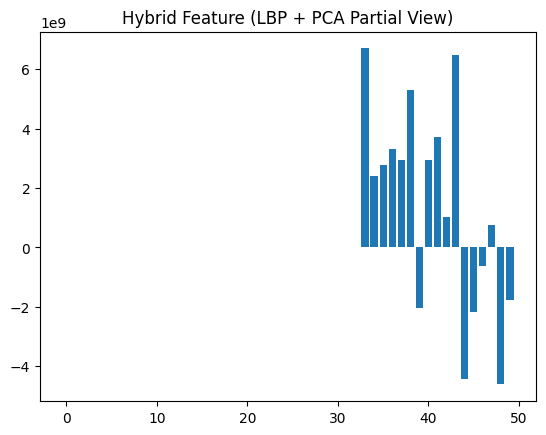

In [ ]:
def visualize_hybrid_feature(face, pca_info):
    lbp = extract_lbp_hist(face, grid_x=6, grid_y=6)
    flat = cv2.resize((face*255).astype(np.uint8), (128,128)).astype(np.float32).flatten().reshape(1,-1)
    flat_s = pca_info['scaler_flat'].transform(flat)
    flat_p = pca_info['pca'].transform(flat_s)
    print("LBP vector length:", lbp.shape[0])
    print("PCA projection length:", flat_p.shape[1])
    plt.bar(range(50), np.hstack([lbp[:25], flat_p[0][:25]]))
    plt.title("Hybrid Feature (LBP + PCA Partial View)")
    plt.show()

# Example
visualize_hybrid_feature(gray_face, models['hybrid_pca_info'])
